# Food Delivery Time estimation

## 1. Data Preparation

### 1.1 Import libraries

In [134]:
from module.distance_calculator import DistanceCalculator

import numpy as np
import pandas as pd

from math import sqrt, cos

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [135]:
f = pd.read_excel("Capstone SampleData 14days.xlsx", sheet_name="Sheet1", header=0)
f["FoodCategories"].value_counts()

อาหารตามสั่ง      6201
อาหารอีสาน         976
ร้านก๋วยเตี๋ยว     917
อาหารทะเล          429
อาหารจานด่วน       335
สปาเก็ตตี้         173
ของหวาน            145
สเต๊ก              111
อาหารเหนือ         110
ขนมจีน              66
สุกี้ยากี้          57
อาหารคลีน           56
ปิ้งย่าง            53
เครื่องดื่ม         53
พิซซ่า              52
Quick Meal          48
อาหารใต้            47
อาหารฮาลาล          45
ร้านอาหาร           45
Fast Food           44
ไก่ทอด              37
Name: FoodCategories, dtype: int64

### 1.2 Exploratory Data Analysis (EDA)

### 1.2.1 Examine daata

In [136]:
# Read in the data
df = pd.read_excel("Capstone SampleData 14days.xlsx", sheet_name="Sheet1", header=0)

In [137]:
# Check the data types
df.head()

,JobAcceptedDate,jobAcceptedTime,calledMerchantTime,arrivedAtMerchantTime,mealPickedUpTime,arrivedAtCustLocationTime,foodDeliveredTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,MerchantName,NationFoodCategory,FoodCategories
0,2020-10-03,20:39:15.840000,20:40:51.840000,20:48:19.840000,20:49:18.840000,21:14:09.840000,21:15:12.840000,13.825853,100.551958,13.825703,100.559309,13.756065,100.562375,3K SEA ZABB,Thai,อาหารทะเล
1,2020-10-01,12:54:34.560000,12:55:38.560000,13:10:26.560000,13:24:56.560000,14:01:00.560000,14:01:39.560000,13.819283,100.561874,13.831056,100.570731,13.774685,100.573913,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
2,2020-10-01,12:32:06.720000,12:32:21.720000,12:41:08.720000,12:46:41.720000,13:22:01.720000,13:22:53.720000,13.827041,100.554284,13.827205,100.536048,13.743898,100.571659,ไก่ย่างห้าดาว กรุงเทพ-นนท์44,Thai,Fast Food
3,2020-10-03,13:19:03.360000,13:20:04.360000,13:32:37.360000,13:45:46.360000,14:14:28.360000,14:15:47.360000,13.820453,100.557910,13.840180,100.542326,13.803957,100.513704,กิวกิวเต้ ประชาชื่น,Japanese,ปิ้งย่าง
4,2020-10-13,11:08:26.880000,11:09:03.880000,11:13:43.880000,11:15:32.880000,11:40:26.880000,11:41:23.880000,13.825773,100.567170,13.827034,100.564534,13.775817,100.575734,ร้านอาหาร วินเทส,Thai,อาหารตามสั่ง


In [138]:
# Check the data shape
df.shape

(10000, 16)

### 1.2.2 Remove unused columns

In [139]:
# Remove the columns that are not needed
drop_list = ["jobAcceptedTime",
             "calledMerchantTime",
             "arrivedAtMerchantTime",
             "foodDeliveredTime",
             "riderInitial.lat",
             "riderInitial.long",
             "MerchantName",
             "NationFoodCategory",
             "FoodCategories"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,mealPickedUpTime,arrivedAtCustLocationTime,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng
0,2020-10-03,20:49:18.840000,21:14:09.840000,13.825703,100.559309,13.756065,100.562375
1,2020-10-01,13:24:56.560000,14:01:00.560000,13.831056,100.570731,13.774685,100.573913
2,2020-10-01,12:46:41.720000,13:22:01.720000,13.827205,100.536048,13.743898,100.571659


### 1.2.3 Change data types (time, date -> datetime)
datetime data type can find interval but both time and date data types cannot.

In [140]:
def to_datetime(df, date_col, time_col):
    return pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str))

In [141]:
if not isinstance(df["mealPickedUpTime"].iloc[0], datetime):
    df["mealPickedUpTime"]    = to_datetime(df, "JobAcceptedDate", "mealPickedUpTime")
if not isinstance(df["arrivedAtCustLocationTime"].iloc[0], datetime):
    df["arrivedAtCustLocationTime"] = to_datetime(df, "JobAcceptedDate", "arrivedAtCustLocationTime")

### 1.2.3 Create target from existed columns

In [142]:
df["DeliveryTime"] = df["arrivedAtCustLocationTime"] - df["mealPickedUpTime"]
df["DeliveryTime (s)"] = df["DeliveryTime"].apply(lambda x: x.total_seconds())
df["DeliveryTime (m)"] = df["DeliveryTime"].apply(lambda x: round(x.total_seconds()/60))

In [143]:
# Remove the columns that are not needed
drop_list = ["JobAcceptedDate",
             "arrivedAtCustLocationTime",
             "mealPickedUpTime",
             "DeliveryTime"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
0,13.825703,100.559309,13.756065,100.562375,1491.0,25
1,13.831056,100.570731,13.774685,100.573913,2164.0,36
2,13.827205,100.536048,13.743898,100.571659,2120.0,35


In [144]:
df["DeliveryTime (s)"].describe()

count    10000.000000
mean      1821.204700
std        755.673662
min        181.000000
25%       1245.000000
50%       1814.000000
75%       2375.000000
max       4271.000000
Name: DeliveryTime (s), dtype: float64

<AxesSubplot: >

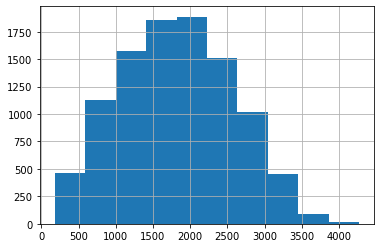

In [145]:
df["DeliveryTime (s)"].hist()

In [146]:
df["DeliveryTime (m)"].describe()

count    10000.000000
mean        30.355000
std         12.599034
min          3.000000
25%         21.000000
50%         30.000000
75%         40.000000
max         71.000000
Name: DeliveryTime (m), dtype: float64

<AxesSubplot: >

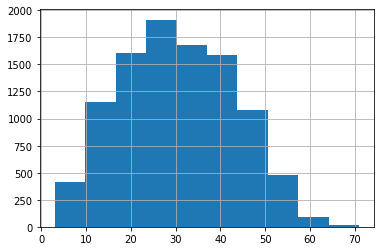

In [147]:
df["DeliveryTime (m)"].hist()

In [148]:
df.head(2)

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m)
0,13.825703,100.559309,13.756065,100.562375,1491.0,25
1,13.831056,100.570731,13.774685,100.573913,2164.0,36


In [149]:
def get_euc(coords_1, coords_2):
    R = 6371000; conversion_const = 0.0174533

    c_1 = (coords_1[0]*conversion_const, coords_1[1]*conversion_const)
    c_2 = (coords_2[0]*conversion_const, coords_2[1]*conversion_const)


    delta_phi = abs(c_1[1]-c_2[1])

    theta = c_1[0]
    delta_theta = abs(c_1[0]-c_2[0])

    del_x = R*cos(theta)*delta_phi 
    del_y = R*delta_theta

    return sqrt(del_x**2+del_y**2)

In [150]:
df["EucDist"] = df.apply(lambda x: get_euc((x["Merchant.Lat"],x["Merchant.Lng"]),(x["Customer.lat"],x["Customer.lng"])), axis=1)

In [151]:
df.head(2)

,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,DeliveryTime (s),DeliveryTime (m),EucDist
0,13.825703,100.559309,13.756065,100.562375,1491.0,25,7750.511440
1,13.831056,100.570731,13.774685,100.573913,2164.0,36,6277.603705


In [152]:
y_s = df.pop("DeliveryTime (s)")
y_m = df.pop("DeliveryTime (m)")
X = df.copy()


## 3. predict as second

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y_s, test_size=0.30, random_state=0)

In [154]:
lr = LinearRegression()
lr.fit(X_train["EucDist"].values.reshape(-1,1), y_train)

LinearRegression()

In [155]:
lr.coef_

array([0.23940568])

In [156]:
predictions = lr.predict(X_test["EucDist"].values.reshape(-1,1))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 292.5809059933975
MSE: 125100.47938519176
RMSE: 353.69546135791984


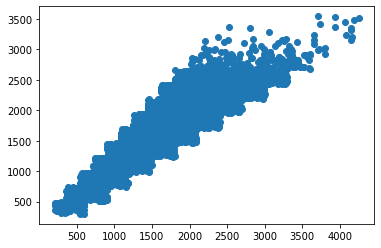

In [157]:
plt.scatter(y_test, predictions)

In [158]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
reg.fit(X_train, y_train)
score = reg.score(X_train, y_train)
print("Train R-square score: ", score)

Train R-square score:  0.9612250936261822


In [159]:
reg.feature_importances_

array([0.02354387, 0.02472238, 0.03333006, 0.02992947, 0.88847423])

In [160]:
predictions = reg.predict(X_test)

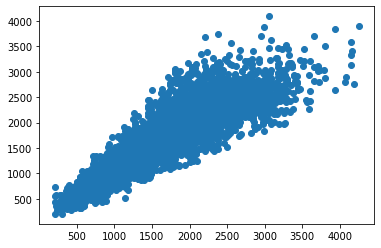

In [161]:
plt.scatter(y_test, predictions)

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_13952/3290896071.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions), bins=50);


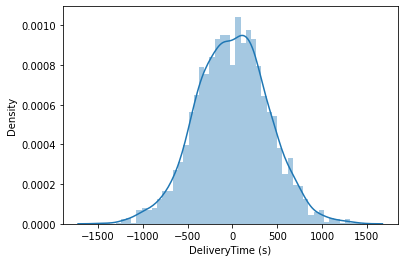

In [162]:
sns.distplot((y_test-predictions), bins=50);

In [163]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 322.01338715571916
MSE: 162939.52335273754
RMSE: 403.6576809039282


In [164]:
result_s = pd.DataFrame({"predict": predictions, "actual": y_test})

In [165]:
result_s.sample(10)

,predict,actual
7257,2335.374708,2603.0
1261,2681.263005,1920.0
6402,436.908568,556.0
700,1509.653839,2247.0
1710,1010.975454,1434.0
1249,1891.493258,2381.0
2749,1608.932712,1605.0
5428,905.278992,675.0
2676,2597.156464,2964.0
7009,1875.308085,2870.0


## 4. predict as minute

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y_m, test_size=0.30, random_state=0)

In [167]:
lr = LinearRegression()
lr.fit(X_train["EucDist"].values.reshape(-1,1), y_train)

LinearRegression()

In [168]:
predictions = lr.predict(X_test["EucDist"].values.reshape(-1,1))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 4.890614447840674
MSE: 34.94976192452479
RMSE: 5.911832366071013


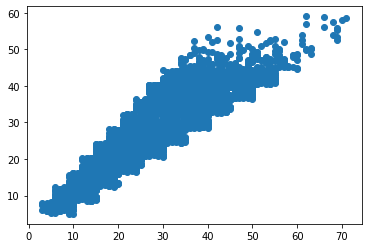

In [169]:
plt.scatter(y_test, predictions)

In [170]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
reg.fit(X_train["EucDist"].values.reshape(-1,1), y_train)
predictions = reg.predict(X_test["EucDist"].values.reshape(-1,1))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.259150103443552
MSE: 44.14809929862388
RMSE: 6.644403607444681


In [171]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
reg.fit(X_train, y_train)
score = reg.score(X_train, y_train)
print("Train R-square score: ", score)

Train R-square score:  0.9611176604122733


In [172]:
predictions = reg.predict(X_test)

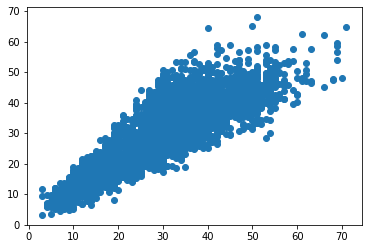

In [173]:
plt.scatter(y_test, predictions)

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_13952/3290896071.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions), bins=50);


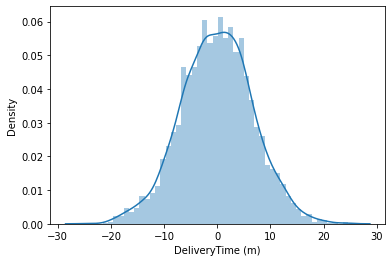

In [174]:
sns.distplot((y_test-predictions), bins=50);

In [175]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 5.372632868819272
MSE: 45.60280679259455
RMSE: 6.7529850283111506


In [176]:
result_m = pd.DataFrame({"predict": predictions, "actual": y_test})

In [177]:
result_m.sample(10)

,predict,actual
5822,19.491279,17
8708,40.006186,46
3730,46.038088,31
1540,34.380802,43
9884,31.045538,39
9752,34.278380,32
5891,31.061127,33
3344,27.635541,16
7635,25.968062,23
944,7.576646,6
